
# What Drives Post Engagement? — Behavioral Insights Project

**Dataset:** Facebook Metrics of a Cosmetic Brand (500 posts, 20 columns)  
**Goal:** Identify which attributes (post type, timing, paid vs. organic, etc.) most influence engagement and convert findings into business recommendations and a dashboard.

**Deliverables:**
- Cleaned dataset with engineered metrics
- Exploratory analysis & visualizations
- Simple predictive models (Linear Regression + Random Forest) to rank drivers
- Exports for Tableau/Power BI and feature importance CSV


In [3]:

# --- Setup & Imports ---
import os
import math
import numpy as np
import pandas as pd

# Visualization (use matplotlib per environment rules)
import matplotlib.pyplot as plt

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Display settings
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 140)

DATA_PATH = "FacebookMetricsofCosmeticBrand.csv"


## 1. Load & Inspect Data

In [4]:

# Load dataset
df_raw = pd.read_csv(DATA_PATH)
print(df_raw.shape)
df_raw.head()


(500, 20)


,Unnamed: 0,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,0,139441,Photo,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,1,139441,Status,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,2,139441,Photo,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80
3,3,139441,Photo,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777
4,4,139441,Photo,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393


In [5]:

# Quick schema & nulls
df_raw.info()
print("\nMissing values by column:")
print(df_raw.isna().sum().sort_values(ascending=False))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 20 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Unnamed: 0                                                           500 non-null    int64  
 1   Page total likes                                                     500 non-null    int64  
 2   Type                                                                 500 non-null    object 
 3   Category                                                             500 non-null    int64  
 4   Post Month                                                           500 non-null    int64  
 5   Post Weekday                                                         500 non-null    int64  
 6   Post Hour                                                            500 non-null    int64  
 7   Paid    

## 2. Clean & Feature Engineer

In [6]:

df = df_raw.copy()

# Drop obvious index placeholder if present
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Ensure expected columns exist
expected_cols = ['Page total likes','Type','Category','Post Month','Post Weekday','Post Hour','Paid',
                 'Lifetime Post Total Reach','Lifetime Post Total Impressions','Lifetime Engaged Users',
                 'Lifetime Post Consumers','Lifetime Post Consumptions',
                 'Lifetime Post Impressions by people who have liked your Page',
                 'Lifetime Post reach by people who like your Page',
                 'Lifetime People who have liked your Page and engaged with your post',
                 'comment','like','share','Total Interactions']

missing_expected = [c for c in expected_cols if c not in df.columns]
if missing_expected:
    print("Warning: Missing expected columns:", missing_expected)

# Basic missing handling
# Paid has 1 missing per earlier inspection — simple fill with 0 (assume organic) or drop.
if 'Paid' in df.columns:
    df['Paid'] = df['Paid'].fillna(0)

# Convert numerics safely
numeric_cols = ['Page total likes','Post Month','Post Weekday','Post Hour','Paid',
                'Lifetime Post Total Reach','Lifetime Post Total Impressions','Lifetime Engaged Users',
                'Lifetime Post Consumers','Lifetime Post Consumptions',
                'Lifetime Post Impressions by people who have liked your Page',
                'Lifetime Post reach by people who like your Page',
                'Lifetime People who have liked your Page and engaged with your post',
                'comment','like','share','Total Interactions']

for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Engagement Rate: interactions divided by reach (guard against zero/NaN)
if 'Lifetime Post Total Reach' in df.columns and 'Total Interactions' in df.columns:
    reach = df['Lifetime Post Total Reach'].replace(0, np.nan)
    df['Engagement Rate'] = df['Total Interactions'] / reach
    # Replace inf/nan with 0 for stability, then you can also choose to dropna
    df['Engagement Rate'] = df['Engagement Rate'].replace([np.inf, -np.inf], np.nan).fillna(0)

# Cast categoricals
for cat_col in ['Type','Category']:
    if cat_col in df.columns:
        df[cat_col] = df[cat_col].astype('category')

# Sanity check
print(df.shape)
df.head()


(500, 20)


,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions,Engagement Rate
0,139441,Photo,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100,0.036337
1,139441,Status,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164,0.015679
2,139441,Photo,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80,0.033154
3,139441,Photo,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777,0.035449
4,139441,Photo,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393,0.054252


## 3. Descriptive Statistics & Distributions

In [7]:

# Summary stats
df.describe(include='all')


,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions,Engagement Rate
count,500.000000,500,500.0,500.000000,500.000000,500.000000,500.000000,500.00000,5.000000e+02,500.000000,500.000000,500.000000,5.000000e+02,500.000000,500.000000,500.00000,499.000000,496.000000,500.000000,500.000000
unique,NaN,4,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Photo,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,426,215.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,123194.176000,NaN,NaN,7.038000,4.150000,7.840000,0.278000,13903.36000,2.958595e+04,920.344000,798.772000,1415.130000,1.676638e+04,6585.488000,609.986000,7.48200,177.945892,27.266129,212.120000,0.024071
std,16272.813214,NaN,NaN,3.307936,2.030701,4.368589,0.448462,22740.78789,7.680325e+04,985.016636,882.505013,2000.594118,5.979102e+04,7682.009405,612.725618,21.18091,323.398742,42.613292,380.233118,0.016499
min,81370.000000,NaN,NaN,1.000000,1.000000,1.000000,0.000000,238.00000,5.700000e+02,9.000000,9.000000,9.000000,5.670000e+02,236.000000,9.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,112676.000000,NaN,NaN,4.000000,2.000000,3.000000,0.000000,3315.00000,5.694750e+03,393.750000,332.500000,509.250000,3.969750e+03,2181.500000,291.000000,1.00000,56.500000,10.000000,71.000000,0.010777
50%,129600.000000,NaN,NaN,7.000000,4.000000,9.000000,0.000000,5281.00000,9.051000e+03,625.500000,551.500000,851.000000,6.255500e+03,3417.000000,412.000000,3.00000,101.000000,19.000000,123.500000,0.021234
75%,136393.000000,NaN,NaN,10.000000,6.000000,11.000000,1.000000,13168.00000,2.208550e+04,1062.000000,955.500000,1463.000000,1.486050e+04,7989.000000,656.250000,7.00000,187.500000,32.250000,228.500000,0.034567


In [8]:

# Average engagement by Type
if 'Type' in df.columns:
    print("Avg Engagement Rate by Type:")
    print(df.groupby('Type')['Engagement Rate'].mean().sort_values(ascending=False))

# Average engagement by Hour
if 'Post Hour' in df.columns:
    print("\nAvg Engagement Rate by Post Hour:")
    print(df.groupby('Post Hour')['Engagement Rate'].mean().sort_values(ascending=False))

# Average engagement by Weekday
if 'Post Weekday' in df.columns:
    print("\nAvg Engagement Rate by Post Weekday:")
    print(df.groupby('Post Weekday')['Engagement Rate'].mean().sort_values(ascending=False))


Avg Engagement Rate by Type:
Type
Photo     0.026060
Status    0.015867
Video     0.008525
Link      0.007266
Name: Engagement Rate, dtype: float64

Avg Engagement Rate by Post Hour:
Post Hour
23    0.047838
20    0.046713
1     0.043881
8     0.028319
3     0.027891
9     0.026630
10    0.025389
11    0.024892
5     0.024304
2     0.023416
4     0.023029
13    0.021188
14    0.020807
18    0.019859
6     0.019010
7     0.018963
17    0.017675
12    0.015828
16    0.014599
15    0.010580
19    0.008403
22    0.006080
Name: Engagement Rate, dtype: float64

Avg Engagement Rate by Post Weekday:
Post Weekday
1    0.026499
5    0.026372
4    0.025109
2    0.024107
6    0.023308
7    0.022973
3    0.020245
Name: Engagement Rate, dtype: float64


/tmp/ipython-input-1975725809.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('Type')['Engagement Rate'].mean().sort_values(ascending=False))


## 4. Visualizations (Matplotlib)

/tmp/ipython-input-3822391975.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ser = df.groupby('Type')['Engagement Rate'].mean().sort_values(ascending=False)


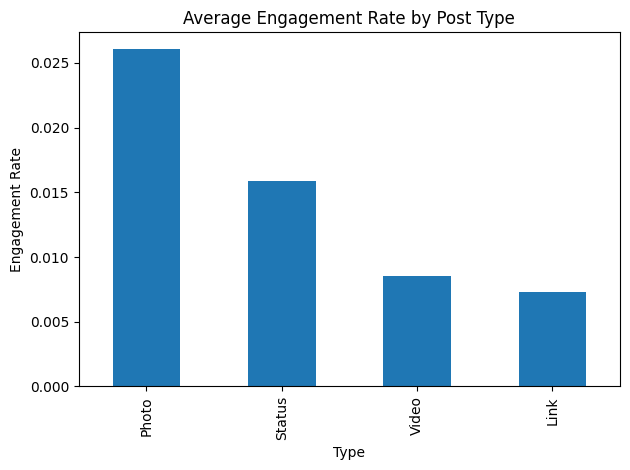

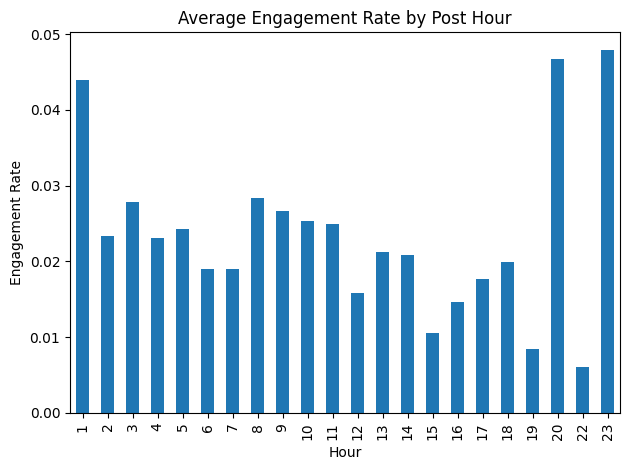

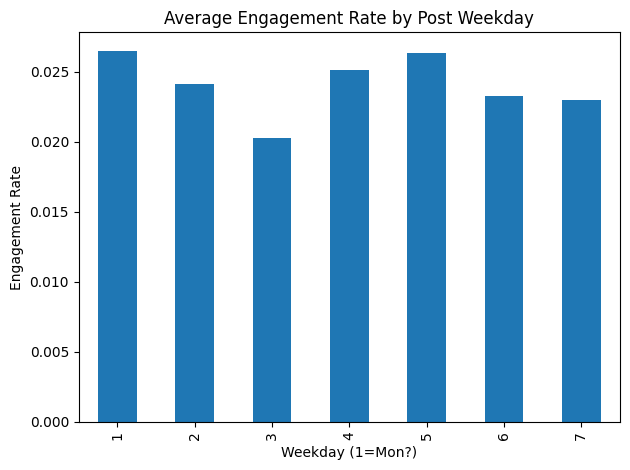

In [9]:

# Helper to show bar plot from groupby series
def bar_from_series(series, title, xlabel, ylabel):
    plt.figure()
    series.plot(kind='bar')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

# Engagement by Type
if 'Type' in df.columns:
    ser = df.groupby('Type')['Engagement Rate'].mean().sort_values(ascending=False)
    bar_from_series(ser, "Average Engagement Rate by Post Type", "Type", "Engagement Rate")

# Engagement by Hour
if 'Post Hour' in df.columns:
    ser = df.groupby('Post Hour')['Engagement Rate'].mean().sort_index()
    bar_from_series(ser, "Average Engagement Rate by Post Hour", "Hour", "Engagement Rate")

# Engagement by Weekday
if 'Post Weekday' in df.columns:
    ser = df.groupby('Post Weekday')['Engagement Rate'].mean().sort_index()
    bar_from_series(ser, "Average Engagement Rate by Post Weekday", "Weekday (1=Mon?)", "Engagement Rate")


/tmp/ipython-input-3275225182.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


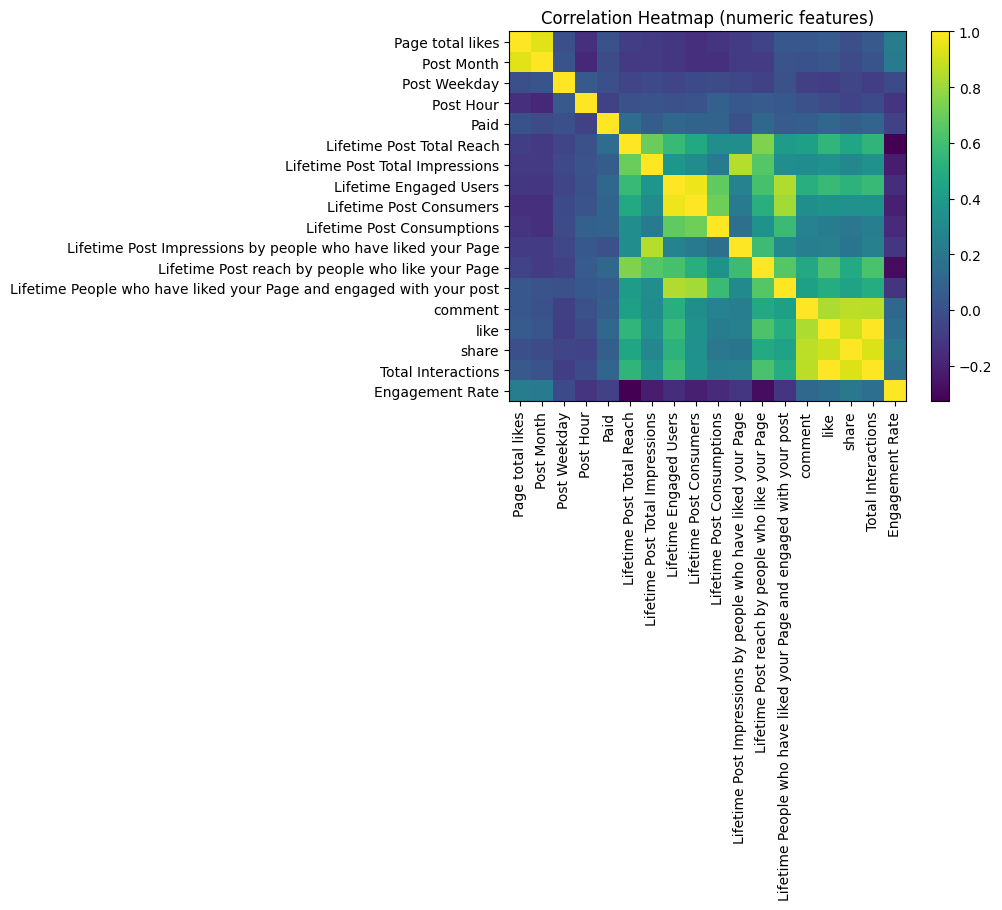

In [10]:

# Correlation heatmap (numeric only)
num_df = df.select_dtypes(include=[np.number])
corr = num_df.corr()
plt.figure()
plt.imshow(corr, interpolation='nearest', aspect='auto')
plt.title("Correlation Heatmap (numeric features)")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.tight_layout()
plt.show()


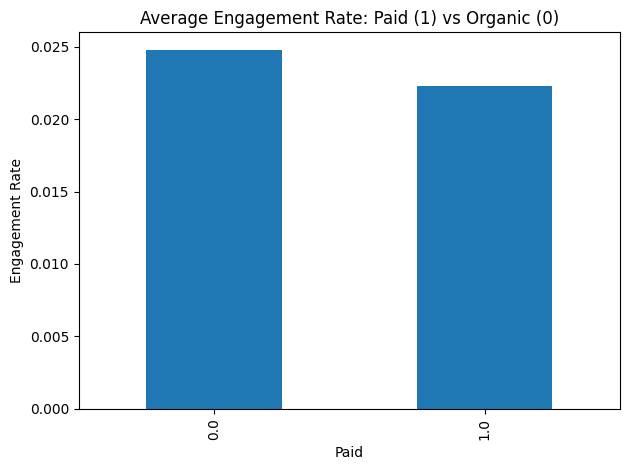

In [11]:

# Paid vs Organic engagement comparison
if 'Paid' in df.columns:
    paid_group = df.groupby('Paid')['Engagement Rate'].mean()
    bar_from_series(paid_group, "Average Engagement Rate: Paid (1) vs Organic (0)", "Paid", "Engagement Rate")


## 5. Modeling: What Predicts Engagement?

Linear Regression — R^2: 0.4318 | MAE: 0.008573

Top LR Coefficients (abs):
Lifetime Engaged Users                                          0.097108
Lifetime Post Consumers                                         0.086660
like                                                            0.033966
Type_Status                                                     0.012941
Category_1                                                      0.010818
Type_Photo                                                      0.009504
Category_2                                                      0.006607
Lifetime Post Total Reach                                       0.005064
Post Month                                                      0.004326
Category_3                                                      0.004211
comment                                                         0.003205
Lifetime Post reach by people who like your Page                0.003163
Type_Link                                       

/tmp/ipython-input-1528223001.py:80: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


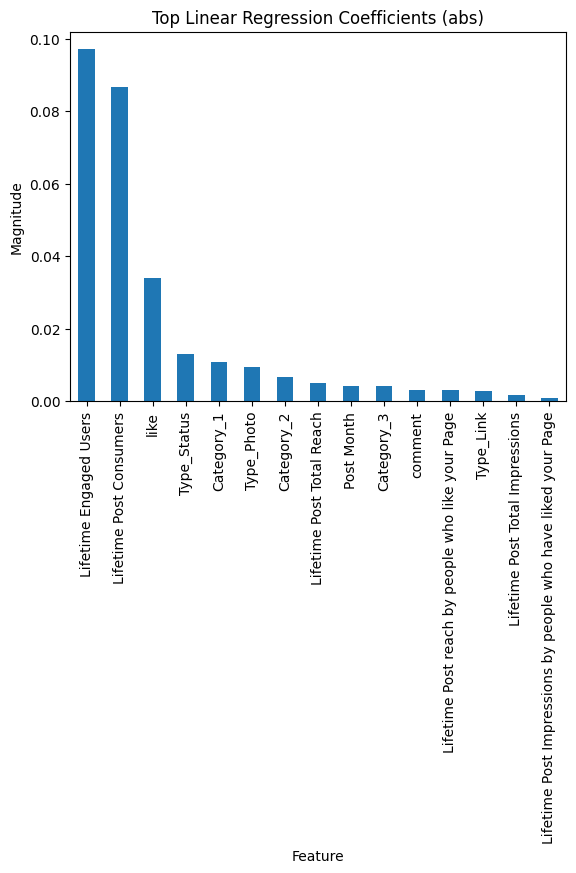


Random Forest — R^2: 0.8577 | MAE: 0.004051

Top RF Feature Importances:
Category_1                                                             0.280032
like                                                                   0.225214
Lifetime Post reach by people who like your Page                       0.085213
Lifetime Post Consumers                                                0.073563
Page total likes                                                       0.053235
Lifetime Post Total Reach                                              0.051847
comment                                                                0.049891
share                                                                  0.047263
Lifetime Post Impressions by people who have liked your Page           0.046628
Lifetime Post Total Impressions                                        0.024417
Post Month                                                             0.014345
Lifetime Post Consumptions                    

/tmp/ipython-input-1528223001.py:100: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


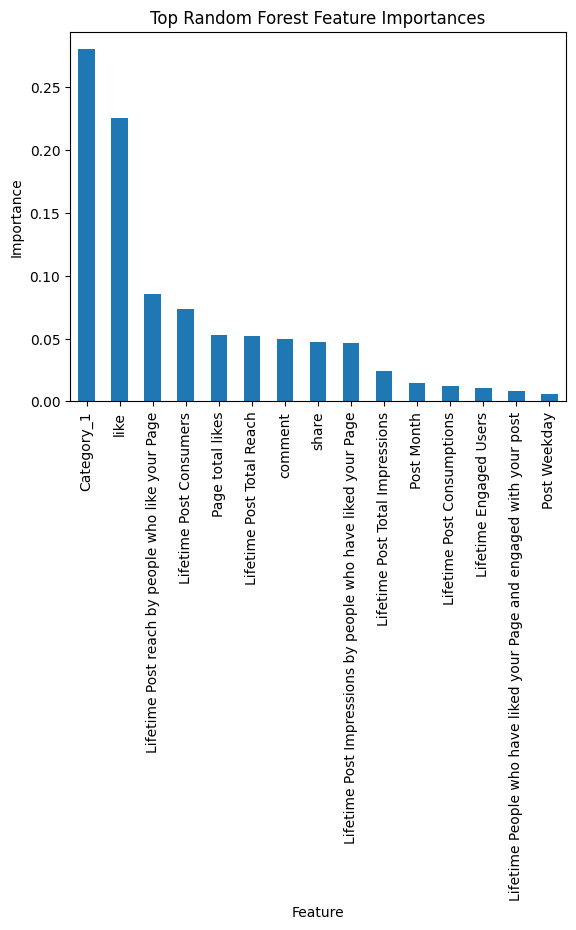

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

target = 'Engagement Rate'
if target not in df.columns:
    raise ValueError("Target 'Engagement Rate' not found.")

# Exclude direct outcome columns to avoid leakage
exclude_cols = [target, 'Total Interactions']
feature_cols = [c for c in df.columns if c not in exclude_cols]

X_raw = df[feature_cols].copy()
y = df[target].values

# Identify column types
num_cols = X_raw.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_raw.columns if c not in num_cols]

# Preprocess: impute + scale numerics; impute + one-hot encode categoricals
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))  # with_mean=False keeps it sparse-friendly
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, num_cols),
        ("cat", categorical_pipeline, cat_cols),
    ],
    remainder='drop'
)

# Models
linreg = LinearRegression()
rf = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)

# Build pipelines end-to-end
linreg_pipe = Pipeline(steps=[("prep", preprocess), ("model", linreg)])
rf_pipe     = Pipeline(steps=[("prep", preprocess), ("model", rf)])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)

# ---- Linear Regression ----
linreg_pipe.fit(X_train, y_train)
y_pred_lr = linreg_pipe.predict(X_test)
print("Linear Regression — R^2: {:.4f} | MAE: {:.6f}".format(r2_score(y_test, y_pred_lr),
                                                             mean_absolute_error(y_test, y_pred_lr)))

# Get LR coefficients mapped to feature names
# We need the one-hot feature names from the ColumnTransformer:
ohe = linreg_pipe.named_steps["prep"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(cat_cols) if len(cat_cols) else np.array([])

final_feature_names = np.concatenate([np.array(num_cols), cat_feature_names])
lr_coefs = pd.Series(linreg_pipe.named_steps["model"].coef_, index=final_feature_names)
coef_series = lr_coefs.abs().sort_values(ascending=False).head(15)
print("\nTop LR Coefficients (abs):")
print(coef_series)

plt.figure()
coef_series.plot(kind='bar')
plt.title("Top Linear Regression Coefficients (abs)")
plt.xlabel("Feature")
plt.ylabel("Magnitude")
plt.tight_layout()
plt.show()

# ---- Random Forest ----
rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)
print("\nRandom Forest — R^2: {:.4f} | MAE: {:.6f}".format(r2_score(y_test, y_pred_rf),
                                                          mean_absolute_error(y_test, y_pred_rf)))

# RF importances mapped to same feature list
rf_importances = pd.Series(rf_pipe.named_steps["model"].feature_importances_, index=final_feature_names)
importances = rf_importances.sort_values(ascending=False).head(15)
print("\nTop RF Feature Importances:")
print(importances)

plt.figure()
importances.plot(kind='bar')
plt.title("Top Random Forest Feature Importances")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()
